# Tutorial on using OpenPIV with PIV Uncertainty Quantification

Authors: @lento234, @alexlib

Documentation: https://pivuq.readthedocs.io/en/latest/

In [1]:
# If you have not installed pivuq yet:
# !conda activate openpiv 
# !pip install pivuq # or !pip install git+https://github.com/lento234/pivuq

In [2]:
%load_ext watermark

In [3]:
import pivuq
from openpiv import tools, pyprocess, scaling, validation, filters
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pivuq'

In [ ]:
%watermark -iv

pivuq     : 0.3.1
numpy     : 1.21.2
openpiv   : 0.23.8
matplotlib: 3.5.2
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]



## Obtain images and ground truth data from pivuq 

In [ ]:
# we can run it from any folder
# path = os.path.dirname(os.path.abspath(__file__))

frame_a  = tools.imread( 'https://github.com/lento234/pivuq/raw/main/examples/data/particledisparity_code_testdata/B00010.tif')
frame_b  = tools.imread( 'https://github.com/lento234/pivuq/raw/main/examples/data/particledisparity_code_testdata/B00011.tif')

image_pair = np.clip(np.array([frame_a, frame_b]), 0, 255).astype('uint8')

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.stack([image_pair[0],0*image_pair[0],image_pair[1]],axis=2)*3)

## PIV cross-correlation using OpenPIV

In [ ]:
%%time

window_size = 24
overlap = int(window_size * 0.5)
search_area_size = 32

u, v, sig2noise = pyprocess.extended_search_area_piv(
    frame_a, frame_b, 
    window_size=window_size, 
    overlap=overlap, 
    dt=1,
    search_area_size=search_area_size,
    sig2noise_method='peak2peak')

# print(u,v,sig2noise)

x, y = pyprocess.get_coordinates(image_size=frame_a.shape, search_area_size=search_area_size, overlap=overlap)
flags_s2n = validation.sig2noise_val(u, v, sig2noise, threshold = 1.3)
flags_g = validation.global_val(u, v, (-1000, 2000), (-1000, 1000) )
flags = flags_g | flags_s2n
u, v = filters.replace_outliers(u, v, flags, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1)#96.52)

# Save
tools.save('test_uq.vec', x, y, u, v, flags)

Wall time: 714 ms


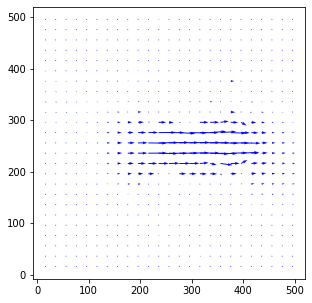

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
tools.display_vector_field('test_uq.vec', scale=50, width=0.0035, ax = ax)

## Uncertainty quantification

Based on paper and source code:

* Sciacchitano, A., Wieneke, B., & Scarano, F. (2013). PIV uncertainty quantification by image matching. Measurement Science and Technology, 24 (4). https://doi.org/10.1088/0957-0233/24/4/045302.
* http://piv.de/uncertainty/?page_id=221


The mean of disparity set inside a window is defined as:
$$
\mu = \frac{1}{N}\sum_{i\in N} c_i d_i,
$$
where $c_i = \sqrt{\Pi(x_i)}$ for $i=1,2,...,N$.

The standard deviation of disparity set inside a window is defined as:
$$
\sigma = \sqrt{\frac{\sum_{i\in N}c_i (d_i - \mu)^2}{\sum_{i\in N}c_i}}.
$$

Thus, the instantaneous error (estimate) vector is defined as:
$$
\hat{\boldsymbol{\delta}} = \{\hat{\delta}_u,\hat{\delta}_v\} = \sqrt{\boldsymbol{\mu}^2 + \left(\frac{\boldsymbol{\sigma}}{\sqrt{N}}\right)^2}
$$


## Loading PIV vectors

In [ ]:
data = np.loadtxt('test_uq.vec', skiprows=1).T

I, J = np.unique(data[0]).shape[0], np.unique(data[1]).shape[0]
X = np.reshape(data[0], (I, J)) # x-coordinates
Y = np.reshape(data[1], (I, J)) # y-coordinates
U = np.stack((np.reshape(data[2], (I, J)), np.reshape(data[3], (I, J))))
# X_i, Y_i = np.meshgrid(np.arange(I)*overlap, np.arange(J)*overlap)

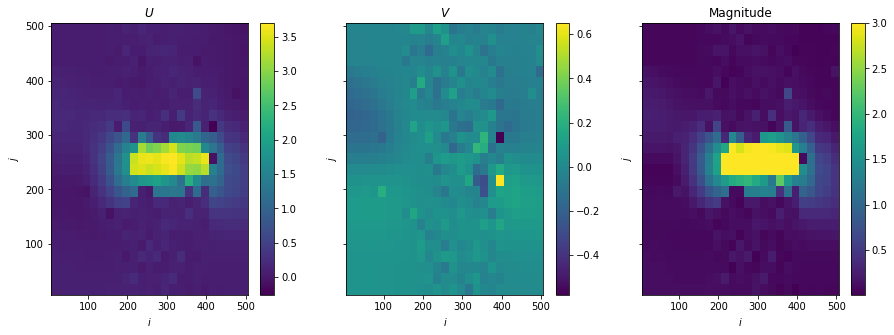

In [ ]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))

for i, (ax, var) in enumerate(zip(axes[:2], ["U", "V"])):
    im = ax.pcolormesh(X, Y, U[i])
    fig.colorbar(im, ax=ax)
    ax.set(title=f"${var}$")

ax = axes[-1]
im = ax.pcolormesh(X, Y, np.linalg.norm(U, axis=0), vmax=3)
fig.colorbar(im, ax=ax)
ax.set(title="Magnitude")

for ax in axes:
    ax.set(xlabel="$i$", ylabel="$j$")

## UQ using PIVUQ

In [ ]:
%%time
X_d, Y_d, delta, N, mu, sigma = pivuq.disparity.sws(
    image_pair,
    U,
    window_size=window_size, # Similar to PIV window size
    window="gaussian", # Best
    radius=1,
    sliding_window_subtraction=True, 
    roi=[10, 450, 220, 430],
    velocity_upsample_kind="linear",
    warp_direction="center", # Depends on original PIV algorithm: "center" is typical
    warp_order=-1, # Whittaker interpolation
    warp_nsteps=1, # Depends on original PIV: 1 step is standard
)

Wall time: 1.45 s


### Plot disparity fields

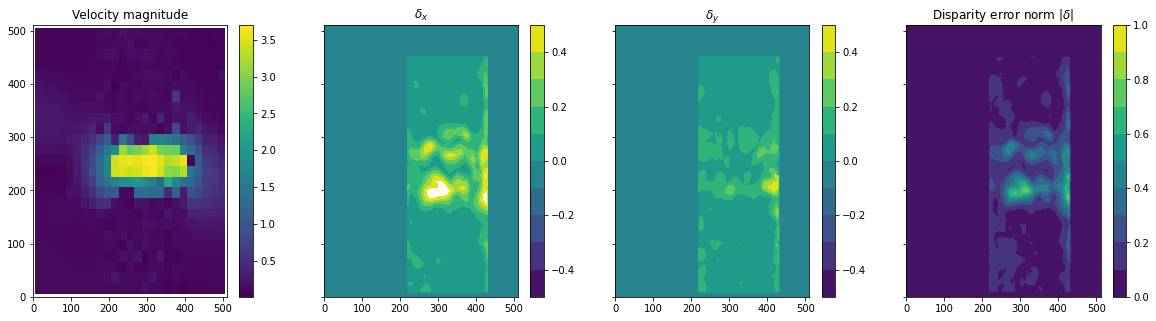

In [ ]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 5))

# Magnitude
ax = axes[0]
im = ax.pcolormesh(X, Y, np.linalg.norm(U, axis=0))
fig.colorbar(im, ax=ax)
ax.set(title="Velocity magnitude")

# Disparity error components
for i, (ax, var) in enumerate(zip(axes[1:3], ["x", "y"])):
    im = ax.contourf(X_d, Y_d, delta[i], np.linspace(-0.5, 0.5, 11))
    fig.colorbar(im, ax=ax)
    ax.set(title=f"$\delta_{var}$")

# Disparity error norm
ax = axes[3]
im = ax.contourf(X_d, Y_d, np.linalg.norm(delta, axis=0), np.linspace(0, 1, 11))
fig.colorbar(im, ax=ax)
ax.set(title="Disparity error norm $|\delta|$");

### Plot disparity histogram

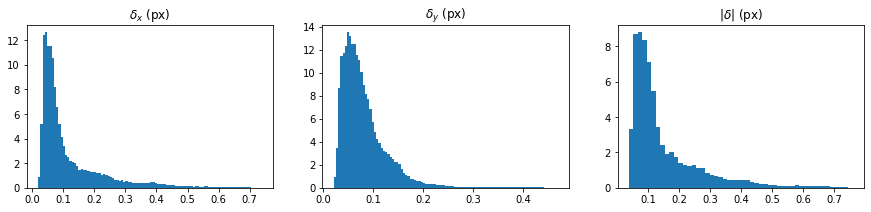

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 3))

for i, (ax, label) in enumerate(zip(axes[:2], [r"$\delta_x$ (px)", r"$\delta_y$ (px)"])):
    values = delta[i].ravel() # Ignoring *zero*-disparity region
    ax.hist(values[np.abs(values) > 0], bins=100, density=True)
    ax.set(title=label)

ax = axes[-1]
values = np.linalg.norm(delta, axis=0).ravel()
ax.hist(values[np.abs(values) > 0], bins=50, density=True)
ax.set(title="$|\delta|$ (px)");